In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import itertools

In [2]:
df=pd.read_csv('product b.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_b= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_b.shape

(60, 1)

In [5]:
sales_b.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
sales_b['Sales'].sum()

70016882

Text(0.5, 1.0, 'Product B')

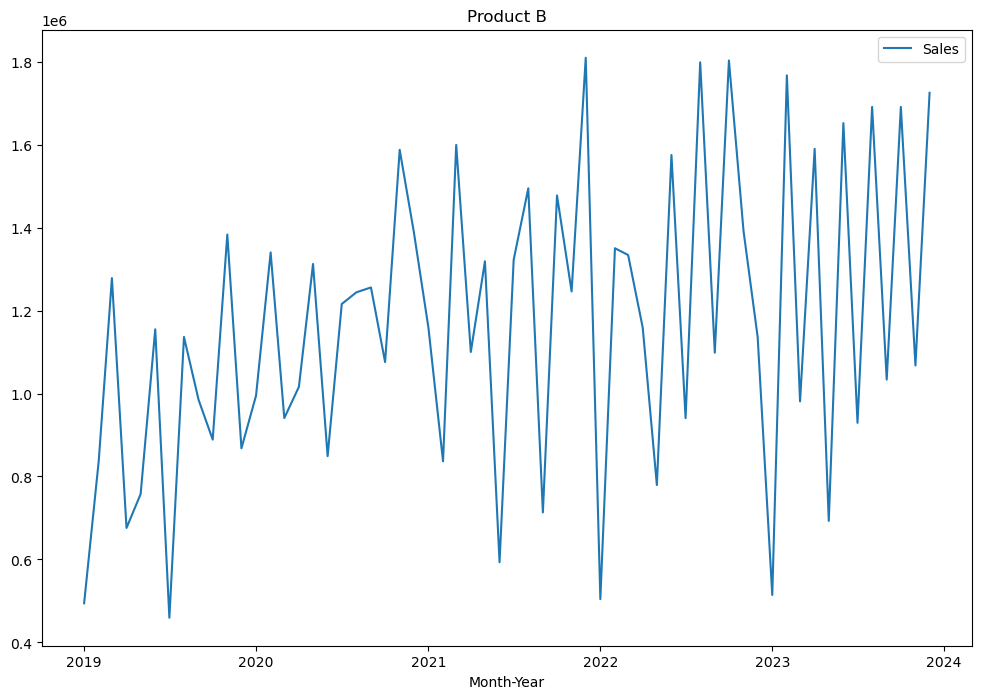

In [7]:
plt.figure(figsize=(12,8))
sns.lineplot(sales_b)
plt.title('Product B')

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [10]:
adf_test(sales_b)

ADF Statistics: -2.263078907366476
p- value: 0.18415230168794178
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [11]:
sales_b_diff= sales_b.diff().dropna()

Text(0.5, 1.0, 'Product B - First Difference')

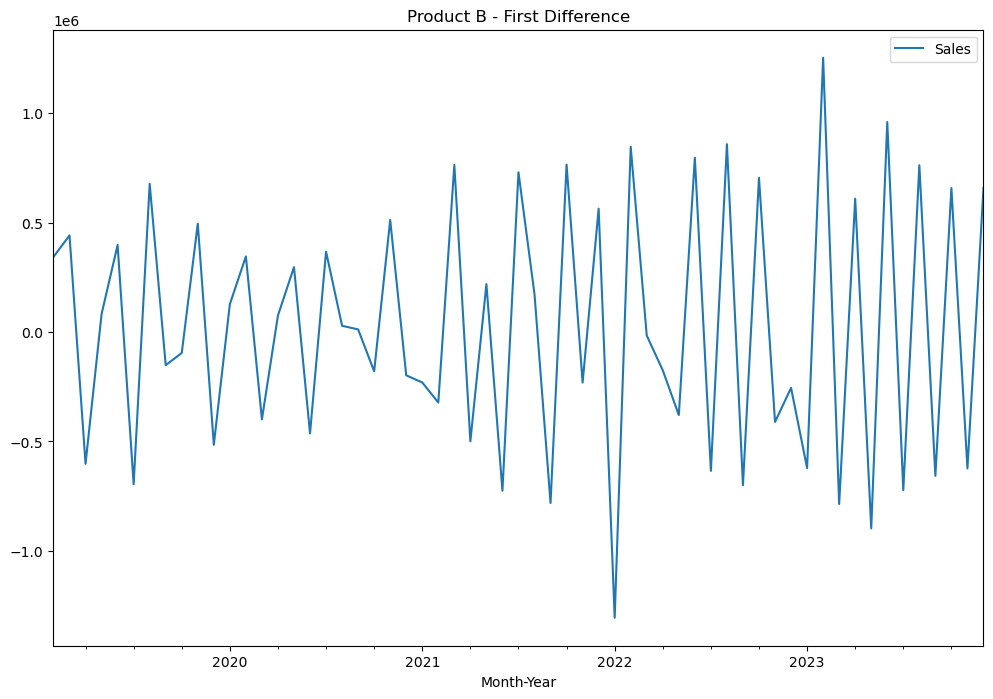

In [12]:
sales_b_diff.plot(figsize=(12,8))
plt.title('Product B - First Difference')

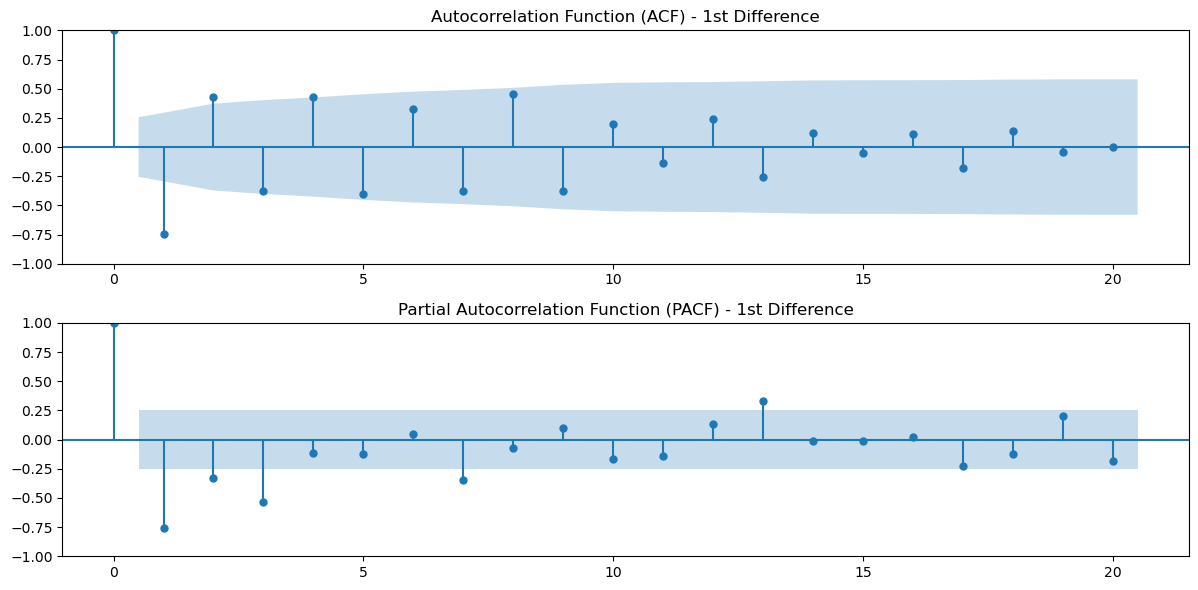

In [13]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_b_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_b_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [14]:
adf_test(sales_b_diff)

ADF Statistics: -10.617041136124557
p- value: 5.639859315327351e-19
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [15]:
train= sales_b[:54]
test=sales_b[54:]

In [16]:
print(len(train),len(test))

54 6


In [17]:
#Finding the best value for ARIMA

#import itertools
#p=d=q=range(0,5)
#pdq = list(itertools.product(p,d,q))

#for param in pdq:
#    try:
#        model_arima = ARIMA(train,order=param)
#        model_arima_fit = model_arima.fit()
#       print(param,model_arima_fit.aic)
#    except:
#        continue
    
# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
# statistical models for a given set of data

# It's like the mean squared error in Regression - The smaller the number, the better

In [18]:
#therefore, the combination p=(0,1,2,3,4,5) d=1 q=(0,1,2,3) must be tested with accuracy metrics and aic

In [19]:
#param = [(0,1,0),(0,1,1),(0,1,2),(0,1,3),(1,1,0),(1,1,1),(1,1,2),(1,1,3),(2,1,0), (2,1,1), (2,1,2),(2,1,3),(3,1,0),(3,1,1),(3,1,2),(3,1,3),(4,1,0),(4,1,1),(4,1,2),(4,1,3),(5,1,0),(5,1,1),(5,1,2),(5,1,3)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [20]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(4):
        # Fit model        
#       model= ARIMA(sales_b, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_b)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [21]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic            mae           mse           rmse
12  3  0  1509.718975  1517.600142  166597.132727  4.435206e+10  210599.284180
19  4  3  1509.740320  1525.502655  275169.522853  1.137792e+11  337311.722207
13  3  1  1510.238744  1520.090204  192980.199155  5.724926e+10  239268.169556
11  2  3  1510.489790  1522.311541  151619.180568  3.191466e+10  178646.756800
7   1  3  1510.656040  1520.507500  145818.298914  3.412537e+10  184730.525101
5   1  1  1510.670943  1516.581818  291901.006198  1.052509e+11  324424.023148
16  4  0  1510.758521  1520.609981  195994.264804  5.732306e+10  239422.347339
17  4  1  1511.250908  1523.072660  175633.654045  4.883975e+10  220997.166651
14  3  2  1511.276333  1523.098085  148857.291857  3.082012e+10  175556.602347
6   1  2  1511.351957  1519.233125  129183.446472  2.456975e+10  156747.422712
2   0  2  1511.424738  1517.335614  326722.465262  1.272040e+11  356656.650359
22  5  2  1511.782838  1527.545174  183037.905372  5

In [22]:
m_arima= ARIMA(train, order=(3,1,0))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   54
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -750.859
Date:                Thu, 09 May 2024   AIC                           1509.719
Time:                        15:22:13   BIC                           1517.600
Sample:                    01-01-2019   HQIC                          1512.750
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1188      0.123     -9.088      0.000      -1.360      -0.878
ar.L2         -0.8218      0.151     -5.450      0.000      -1.117      -0.526
ar.L3         -0.5348      0.106     -5.026      0.0

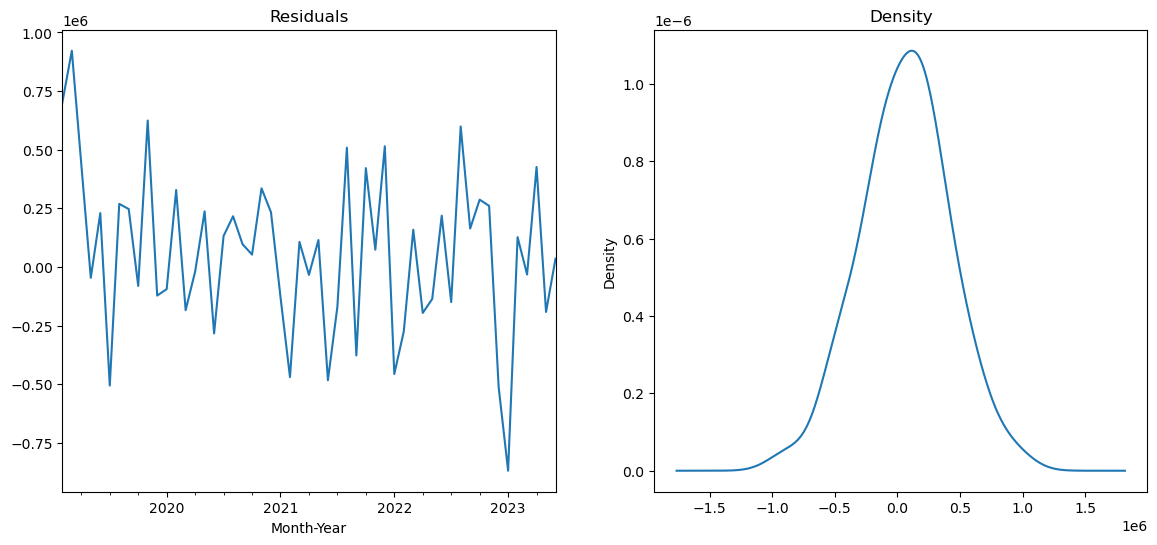

In [23]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

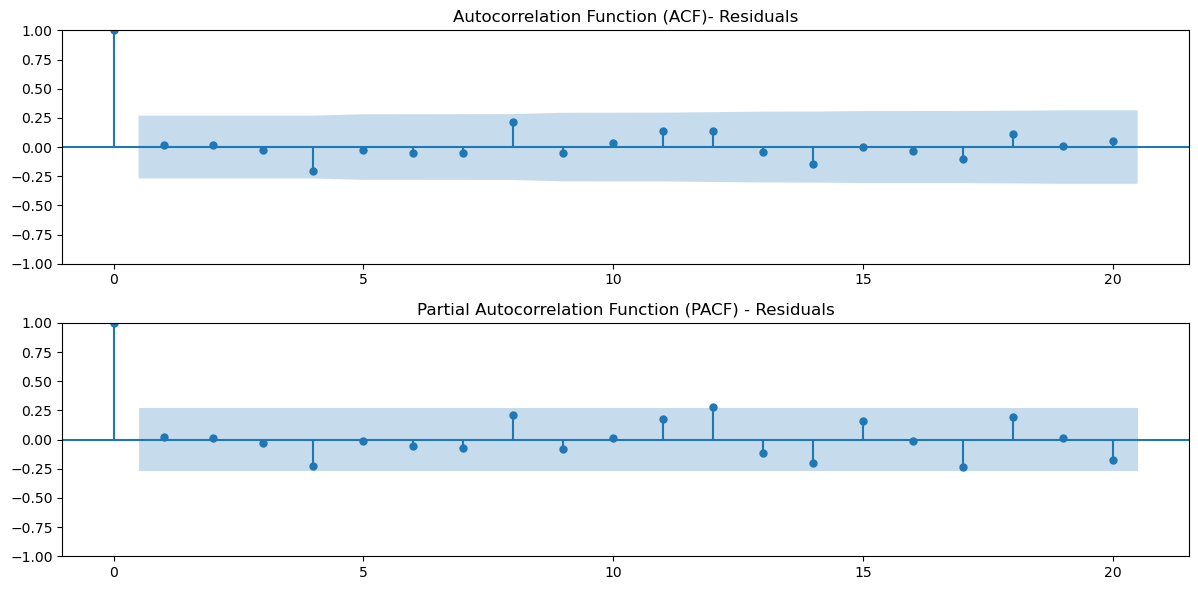

In [24]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

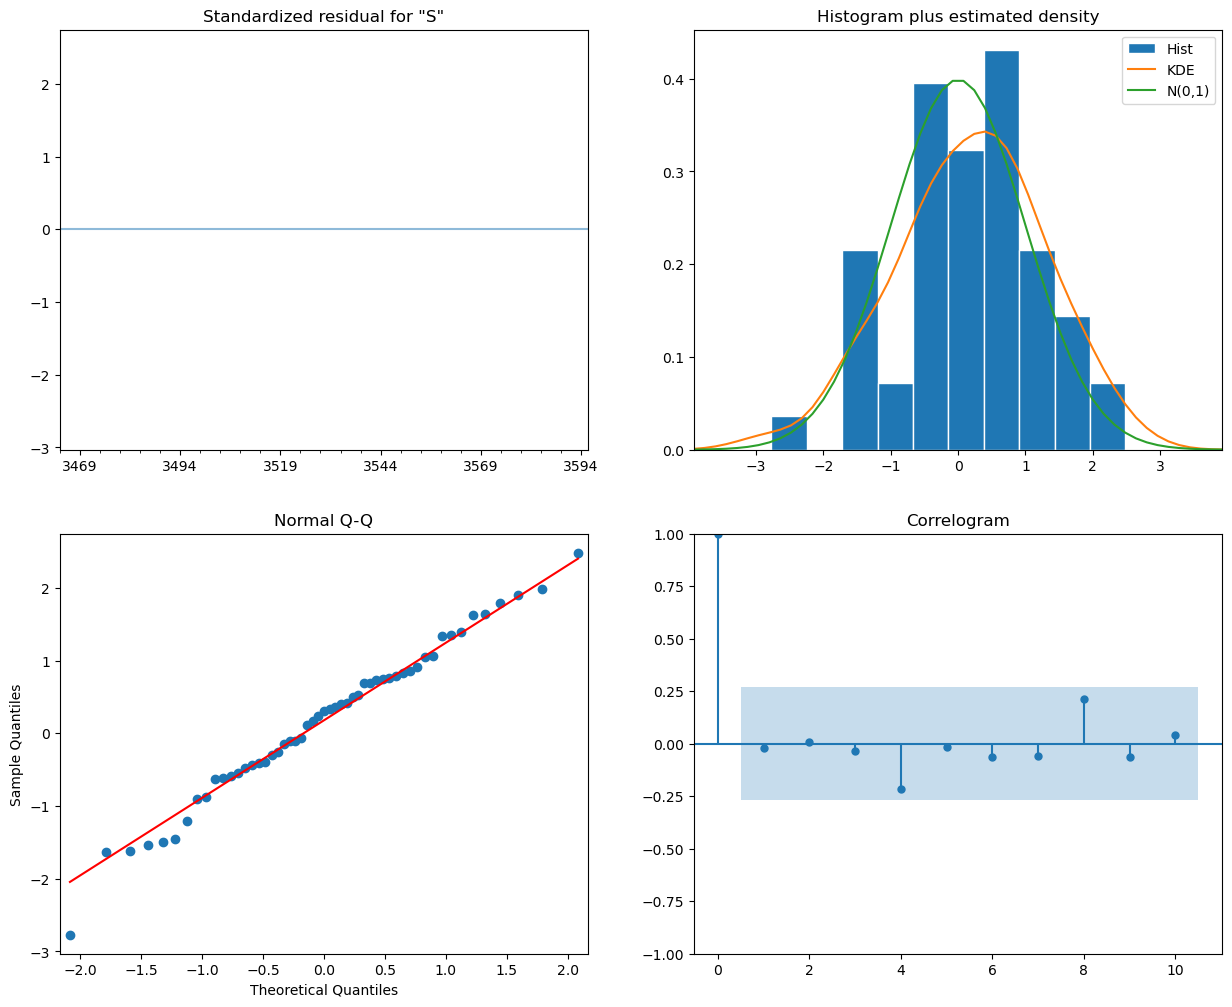

In [25]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [26]:
#pred_in_sample = model_arima.get_prediction(start=len(train), end=(len(sales_b)-1))
#sales_b['Forecast_ARIMA_p']=[None]*len(train) + list(pred)

In [27]:
#plt.figure(figsize=(12, 8))
#sns.lineplot(sales_b[['Sales','Forecast_ARIMA_p']])
#plt.title('Product B')
#plt.show()

In [28]:
pred=model_arima.predict(start=len(train), end=(len(sales_b)-1), dynamic = True)
sales_b['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_b.plot()

In [29]:
#pred=model_arima.forecast(steps= len(test))
#sales_b['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_b.plot()

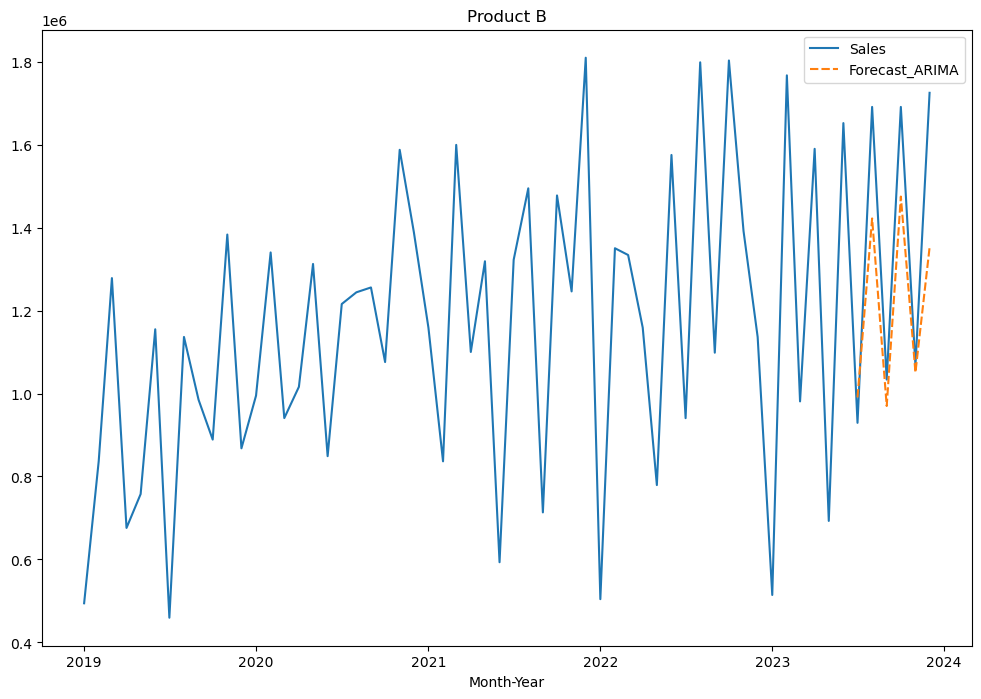

In [30]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales','Forecast_ARIMA']])
plt.title('Product B')
plt.show()

In [31]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 166597.13272748858
MAPE - ARIMA: 0.1077021100056647
MSE - ARIMA: 44352058496.92872
RMSE - ARIMA: 210599.28417952592


# FORECASTING

In [32]:
f_arima= ARIMA(sales_b['Sales'], order=(3,1,0))
model_f_arima=f_arima.fit()

In [33]:
forecast_=model_f_arima.predict(start=len(sales_b), end=(len(sales_b)+5), dynamic = True)

In [34]:
forecast_

2024-01-01    1.133624e+06
2024-02-01    1.604613e+06
2024-03-01    1.196922e+06
2024-04-01    1.595129e+06
2024-05-01    1.221712e+06
2024-06-01    1.540496e+06
Freq: MS, Name: predicted_mean, dtype: float64

Text(0.5, 1.0, 'Product B')

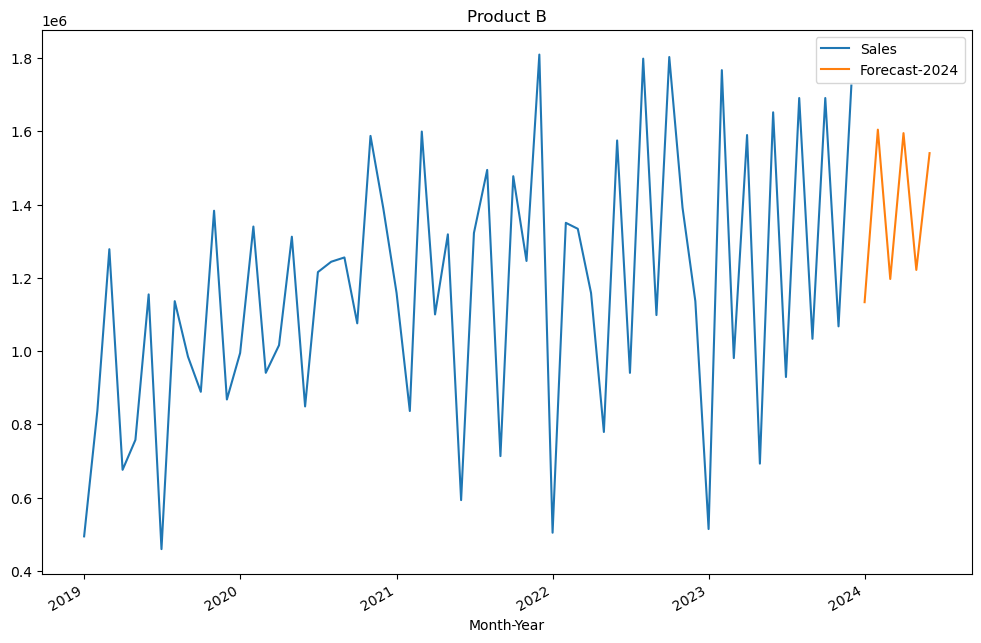

In [35]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales']])
forecast_.plot(legend=True, label='Forecast-2024')
plt.title('Product B')

In [36]:
arima_forecast_model=model_f_arima.get_forecast(steps=6)

mean_forecast= arima_forecast_model.predicted_mean
dates = mean_forecast.index

confidence_intervals= arima_forecast_model.conf_int()

In [37]:
print(mean_forecast,confidence_intervals)

2024-01-01    1.133624e+06
2024-02-01    1.604613e+06
2024-03-01    1.196922e+06
2024-04-01    1.595129e+06
2024-05-01    1.221712e+06
2024-06-01    1.540496e+06
Freq: MS, Name: predicted_mean, dtype: float64              lower Sales   upper Sales
2024-01-01  5.451352e+05  1.722113e+06
2024-02-01  1.011557e+06  2.197668e+06
2024-03-01  5.730534e+05  1.820791e+06
2024-04-01  9.616281e+05  2.228630e+06
2024-05-01  4.991326e+05  1.944292e+06
2024-06-01  8.179107e+05  2.263082e+06


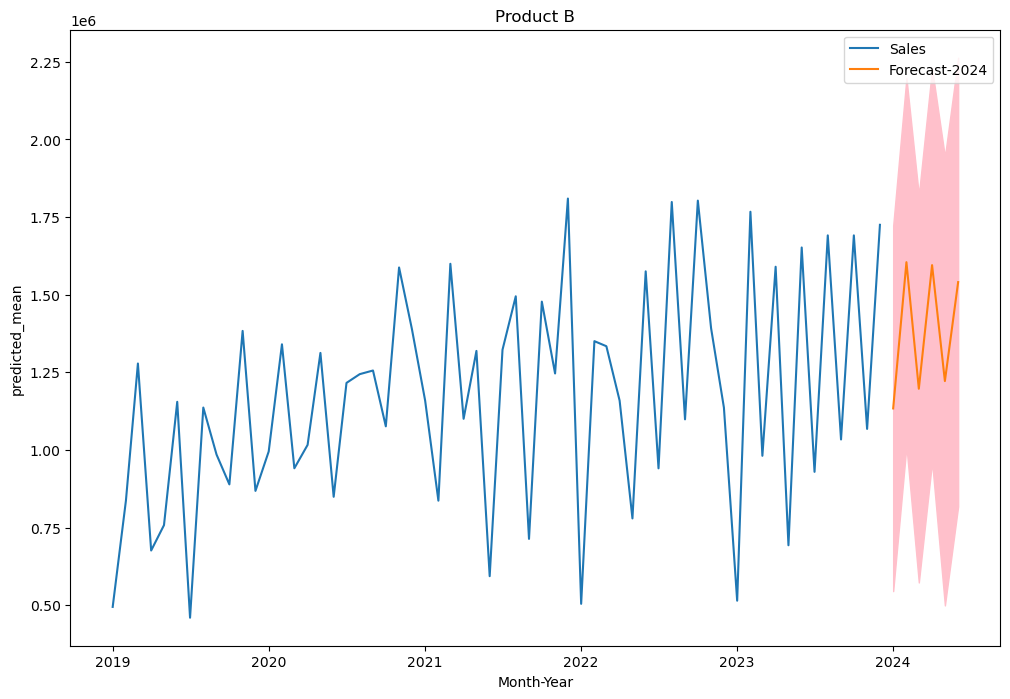

In [38]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales']])
sns.lineplot(mean_forecast,label='Forecast-2024')
#plt.plot(mean_forecast,color='red',label='Forecast-2024')
plt.fill_between(dates,confidence_intervals['lower Sales'],confidence_intervals['upper Sales'],color='pink')
plt.title('Product B')
plt.show()

# SARIMA

In [39]:
import statsmodels.api as sm

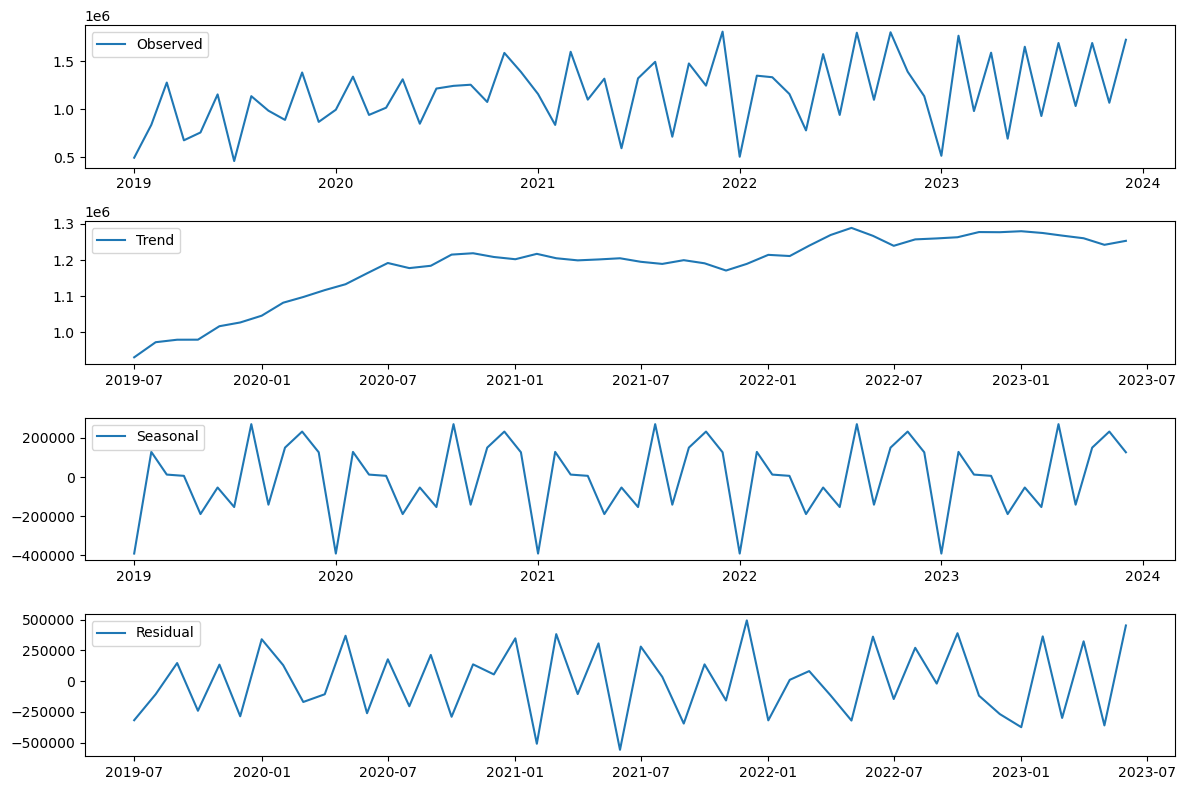

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_b['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

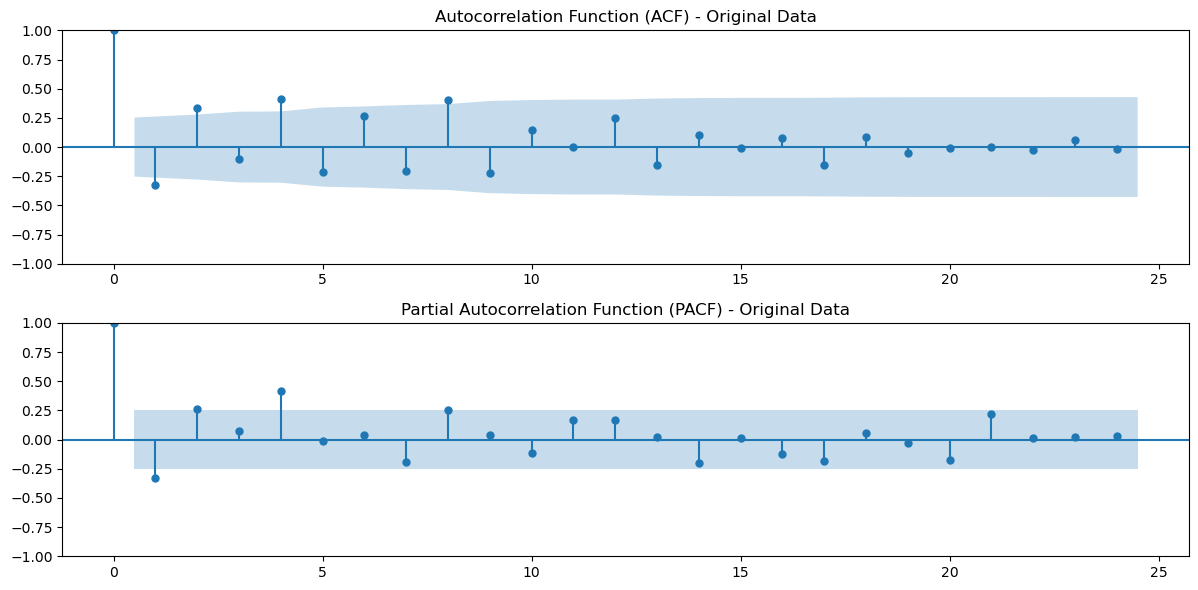

In [41]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_b['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_b['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

In [42]:
# Plot
#fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
#axes[0].plot(sales_b['Sales'], label='Original Series')
#axes[0].plot(sales_b['Sales'].diff(1), label='Usual Differencing')
#axes[0].set_title('Usual Differencing')
#axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
#axes[1].plot(sales_b['Sales'], label='Original Series')
#axes[1].plot(sales_b['Sales'].diff(12), label='Seasonal Differencing', color='green')
#axes[1].set_title('Seasonal Differencing')
#plt.legend(loc='upper left', fontsize=10)
#plt.suptitle('Product B', fontsize=16)
#plt.show()

In [43]:
# Plot ACF and PACF
#plt.figure(figsize=(12, 6))
#plt.subplot(211)
#plot_acf(sales_b['Sales'].diff(12).dropna(), lags=22, ax=plt.gca())
#plt.title('Autocorrelation Function (ACF) - Seasonal Difference')

#plt.subplot(212)
#plot_pacf(sales_b['Sales'].diff(12).dropna(), lags=22, ax=plt.gca())
#plt.title('Partial Autocorrelation Function (PACF) - Seasonal Difference')

#plt.tight_layout()
#plt.show()

In [53]:
order_SARIMAX=[]
# Loop over P order
for P in range(4):
    # Loop over Q order
    for Q in range(4):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(3, 1, 0), seasonal_order=(P, 1, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=54, end=59, dynamic=True)
#        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])


In [54]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q          aic          bic            mae           mse
1   0  1  1178.081844  1186.649704  196458.932667  1.985243e+10
8   2  0  1178.433169  1188.714602  196458.932667  3.382384e+10
2   0  2  1179.569435  1189.850868  196458.932667  2.699493e+10
5   1  1  1179.772578  1190.054011  196458.932667  2.235085e+10
12  3  0  1180.062165  1192.057169  196458.932667  3.676237e+10
9   2  1  1180.095645  1192.090650  196458.932667  3.534652e+10
3   0  3  1180.216217  1192.211221  196458.932667  3.315043e+10
6   1  2  1180.759987  1192.754992  196458.932667  2.788745e+10
13  3  1  1181.996210  1195.704786  196458.932667  3.893776e+10
10  2  2  1182.007890  1195.716466  196458.932667  4.249388e+10
7   1  3  1182.213992  1195.922569  196458.932667  3.388040e+10
4   1  0  1183.843565  1192.411425  196458.932667  3.893814e+10
14  3  2  1183.943802  1199.365950  196458.932667  4.311570e+10
11  2  3  1183.975430  1199.397578  196458.932667  4.184169e+10
15  3  3  1185.937404  1203.073125  1964

In [55]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(3,1,0),seasonal_order=(0,1,1,12))
sarima_model=sarima.fit()

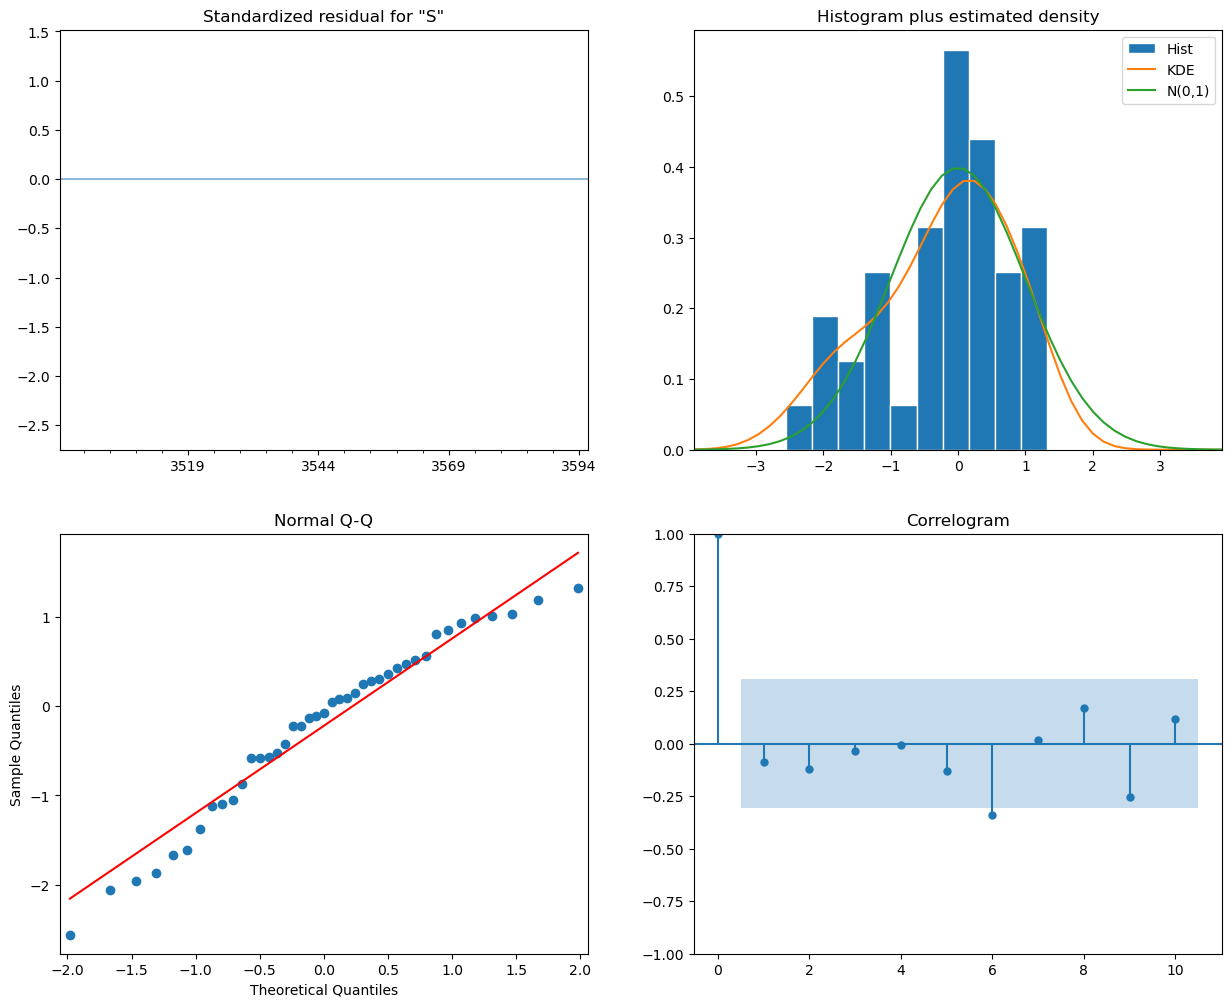

In [56]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [57]:
forecast_test_sarima=sarima_model.predict(start=54,end=59,dynamic=True)

In [58]:
sales_b['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product B')

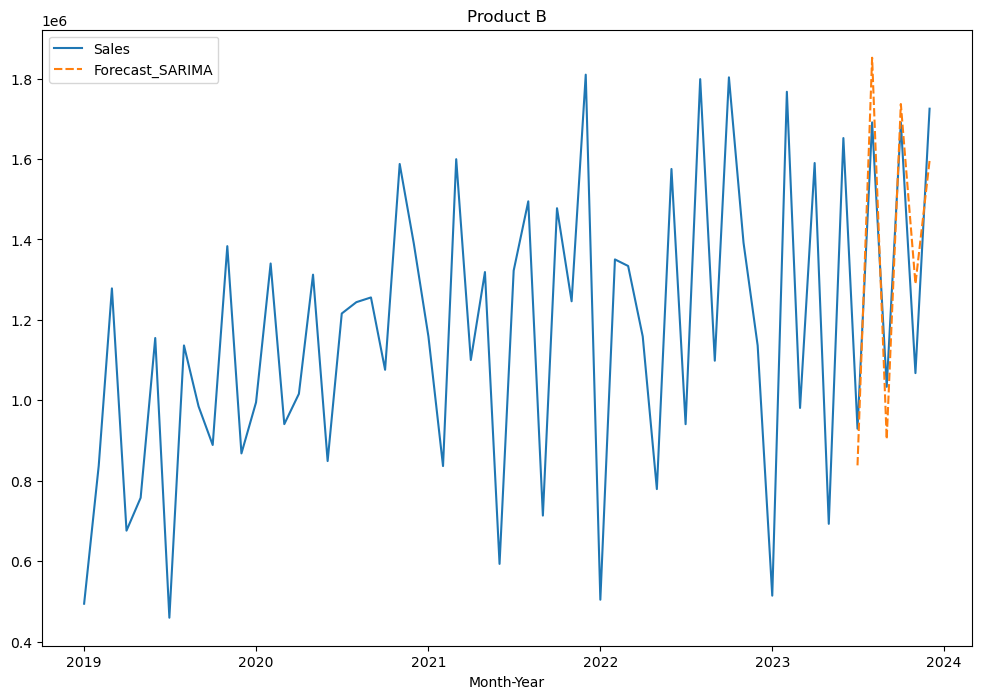

In [59]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales','Forecast_SARIMA']])
plt.title('Product B')

In [60]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 129784.561
MAPE - SARIMA: 0.105
MSE - SARIMA: 19852430574.486
RMSE - SARIMA: 140898.654


# FORECASTING

In [53]:
sarima_forecast=sm.tsa.statespace.SARIMAX(sales_b['Sales'],order=(3,1,0),seasonal_order=(0,1,1,12))
sarima_model_f=sarima_forecast.fit()

In [54]:
forecast_sarima=sarima_model_f.predict(start=60,end=65,dynamic=True)

In [55]:
forecast_sarima

2024-01-01    7.784586e+05
2024-02-01    1.713408e+06
2024-03-01    1.266450e+06
2024-04-01    1.597900e+06
2024-05-01    1.056186e+06
2024-06-01    1.599977e+06
Freq: MS, Name: predicted_mean, dtype: float64

Text(0.5, 1.0, 'Product B')

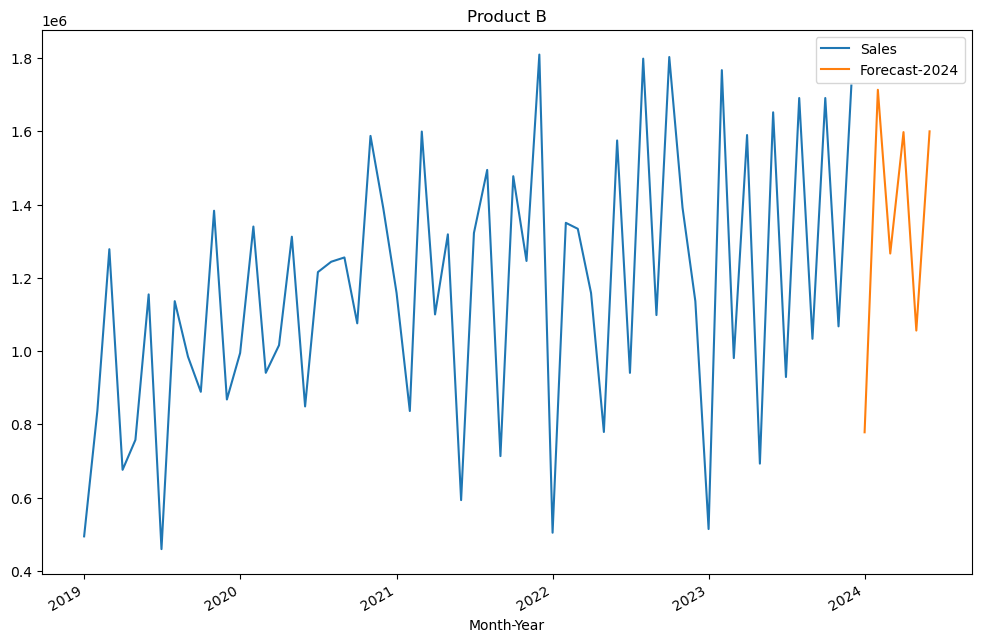

In [56]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales']])
forecast_sarima.plot(legend=True, label='Forecast-2024')
plt.title('Product B')

In [57]:
sarima_forecast_model=sarima_model_f.get_forecast(steps=6)

mean_forecast_sarima= sarima_forecast_model.predicted_mean
dates = mean_forecast_sarima.index

confidence_intervals_sarima= sarima_forecast_model.conf_int()

In [58]:
print(mean_forecast_sarima,confidence_intervals_sarima)

2024-01-01    7.784586e+05
2024-02-01    1.713408e+06
2024-03-01    1.266450e+06
2024-04-01    1.597900e+06
2024-05-01    1.056186e+06
2024-06-01    1.599977e+06
Freq: MS, Name: predicted_mean, dtype: float64              lower Sales   upper Sales
2024-01-01  8.363262e+04  1.473285e+06
2024-02-01  1.019362e+06  2.407454e+06
2024-03-01  4.888981e+05  2.044001e+06
2024-04-01  8.132658e+05  2.382534e+06
2024-05-01  1.754132e+05  1.936959e+06
2024-06-01  7.138609e+05  2.486093e+06


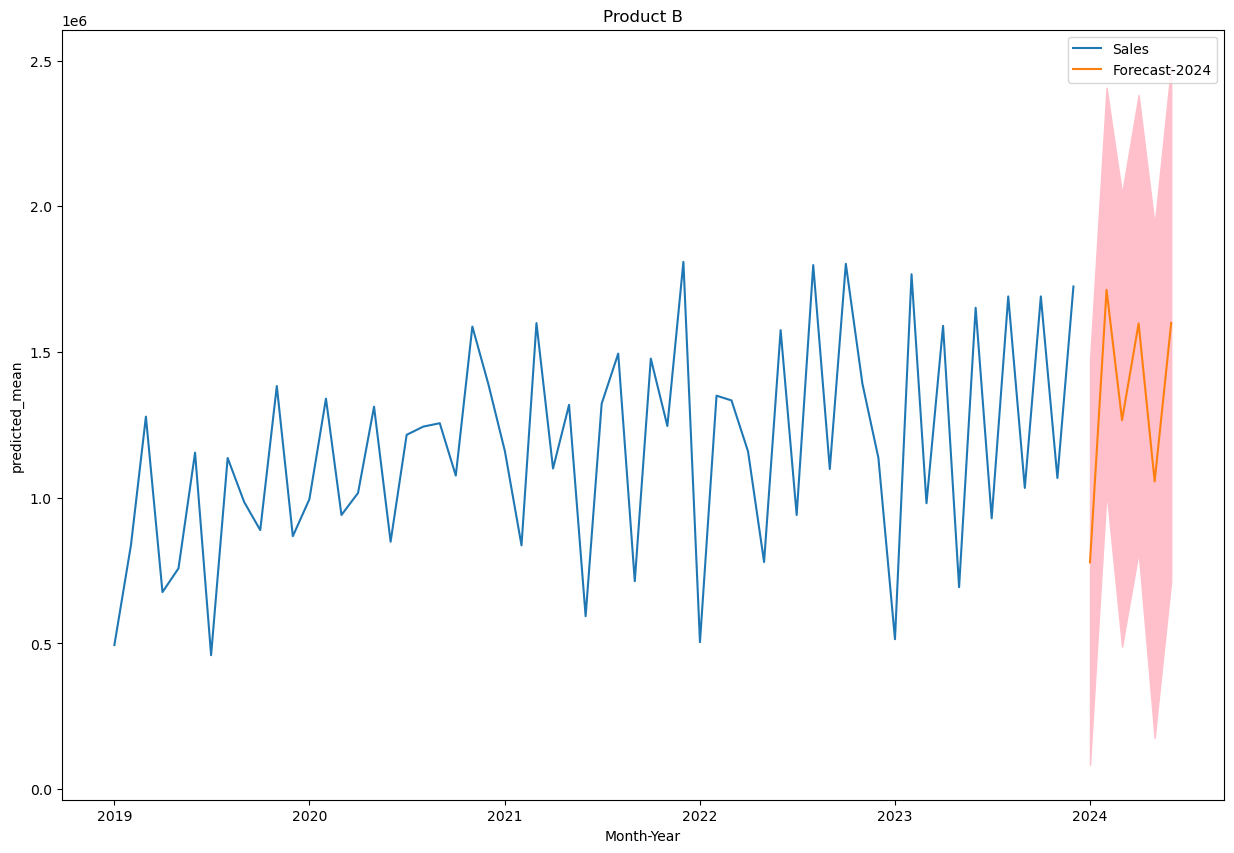

In [59]:
plt.figure(figsize=(15, 10))
sns.lineplot(sales_b[['Sales']])
sns.lineplot(mean_forecast_sarima,label='Forecast-2024')
#plt.plot(mean_forecast,color='red',label='Forecast-2024')
plt.fill_between(dates,confidence_intervals_sarima['lower Sales'],confidence_intervals_sarima['upper Sales'],color='pink')
plt.title('Product B')
plt.show()

# AUTO-ARIMA

In [61]:
import pmdarima as pm

In [63]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=5,max_q=3,
                          start_P=0, D=0, start_Q=0, max_P=4 ,max_Q=4 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1559.555, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1557.064, Time=0.07 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1556.276, Time=0.19 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=1558.273, Time=0.39 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=1559.992, Time=1.72 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1559.598, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1557.081, Time=0.12 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1558.274, Time=0.30 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=1560.130, Time=1.48 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=1561.916, Time=3.97 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1557.757, Time=0.12 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1557.940, Time=0.57 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1559.793, Time=0.44 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=1561.792, Time=1.46 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=1558.306, Time=0.49

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True)

In [64]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   54
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -747.556
Date:                            Thu, 09 May 2024   AIC                           1505.112
Time:                                    15:28:14   BIC                           1514.963
Sample:                                01-01-2019   HQIC                          1508.900
                                     - 06-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.996e+04    1.3e+04      1.538      0.124   -5479.007    4.54e+04
ar.L1         -0.4477      0.171     -2.614      0.009      -0.783      -0.112
ma.L1         -0.8422      0.121     -6.986      0.000      -1.079      -0.606
ma.S.L12       0.4670      0.199      2.349      0.019       0.077       0.857
sigma2      1.092e+11      0.002   5.39e+13      0.000    1.09e+11    1.09e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 1.25
Prob(Q):                              0.63   Prob(JB):                         0.54
Heteroskedasticity (H):               1.21   Skew:                            -0.37
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.18e+29. Standard errors may be unstable.
"""

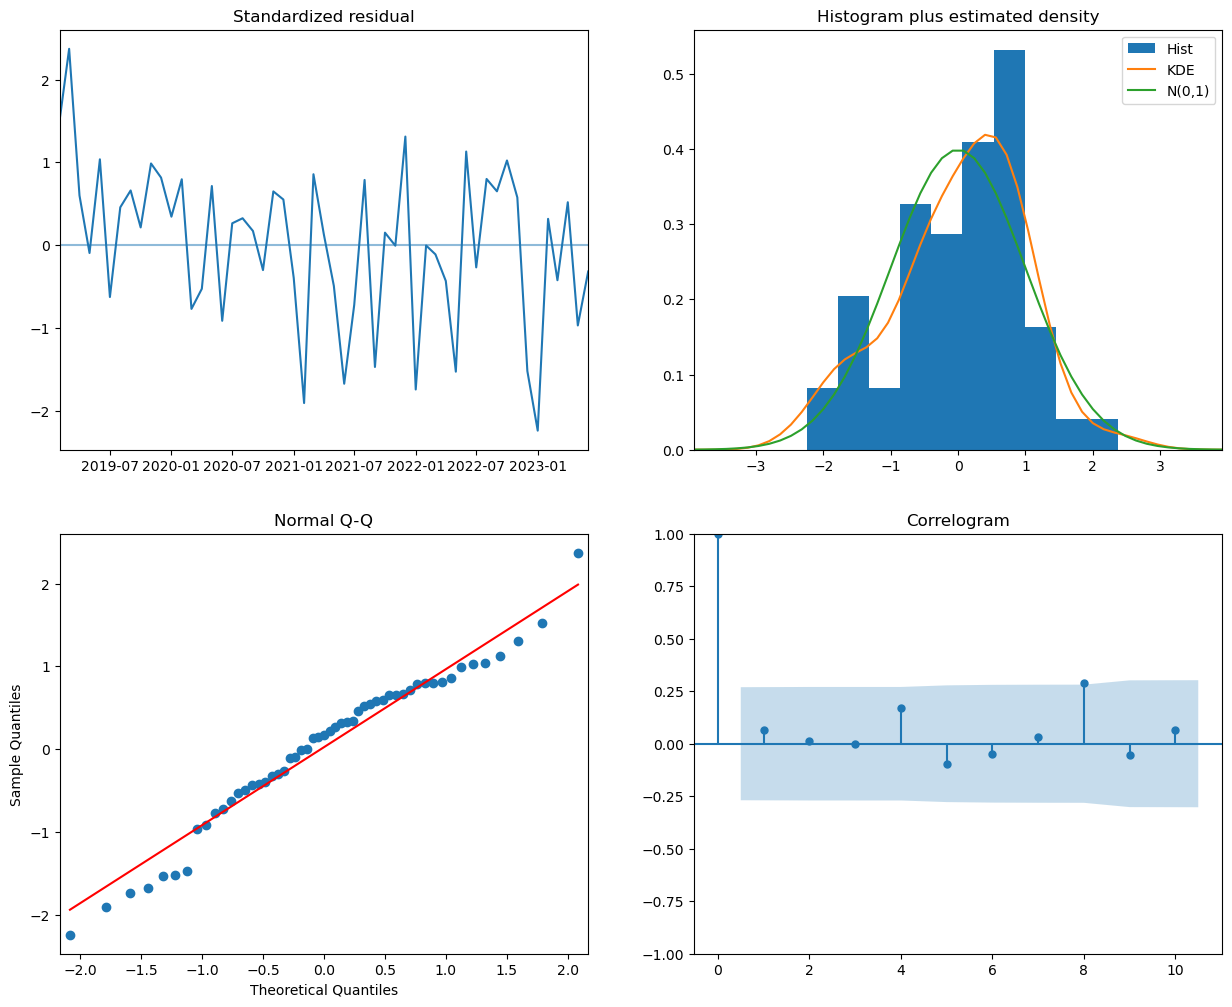

In [65]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [66]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_b['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_b[['Sales','Forecast_AUTO ARIMA']].plot()

Text(0.5, 1.0, 'Product B')

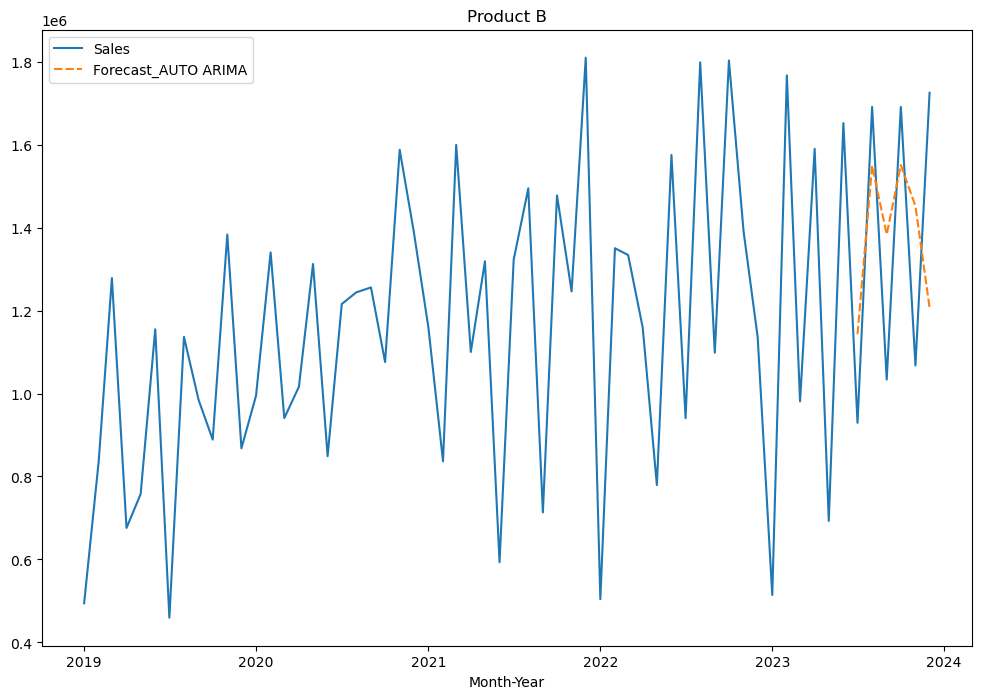

In [67]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product B')

In [68]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 291387.67920569534
MAPE - AUTO ARIMA: 0.23262955579809455
MSE - AUTO ARIMA: 104031582112.00275
RMSE - AUTO ARIMA: 322539.2722010806


# FORECASTING

In [69]:
auto_arima_forecast= pm.auto_arima(sales_b['Sales'], start_p=0, d=1, start_q=0, max_p=5,max_q=3,
                          start_P=0, D=1, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_forecast

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1397.129, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1396.507, Time=0.11 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1392.048, Time=0.24 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1394.481, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1392.939, Time=0.41 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1389.866, Time=0.22 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=1394.602, Time=0.42 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1360.874, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1355.622, Time=0.10 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1356.641, Time=0.31 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1358.464, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1357.036, Time=0.21 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1357.967, Time=0.46 sec
 ARIM

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [70]:
forecast_autoarima= auto_arima_forecast.predict(n_periods=6)

In [71]:
forecast_autoarima

2024-01-01    7.784586e+05
2024-02-01    1.713408e+06
2024-03-01    1.266450e+06
2024-04-01    1.597900e+06
2024-05-01    1.056186e+06
2024-06-01    1.599977e+06
Freq: MS, dtype: float64

Text(0.5, 1.0, 'Product B')

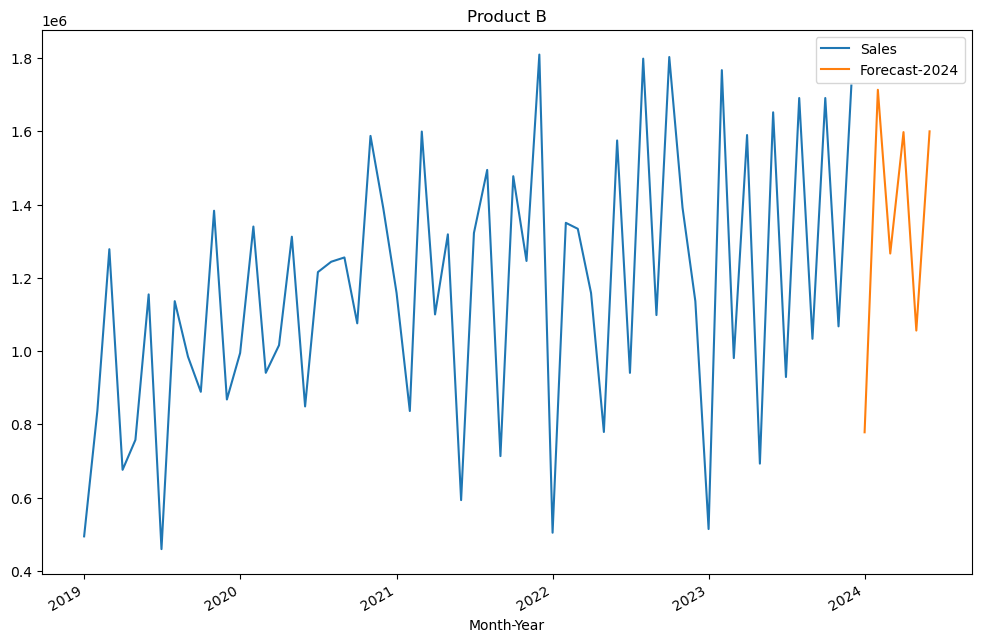

In [72]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales']])
forecast_autoarima.plot(legend=True, label='Forecast-2024')
plt.title('Product B')

In [66]:
sales_b.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,514369,NaN,NaN,NaN
2023-02-01,1767039,NaN,NaN,NaN
2023-03-01,981026,NaN,NaN,NaN
2023-04-01,1589911,NaN,NaN,NaN
2023-05-01,692905,NaN,NaN,NaN
2023-06-01,1651940,NaN,NaN,NaN
2023-07-01,929333,9.905082e+05,8.382960e+05,8.382960e+05
2023-08-01,1690948,1.422065e+06,1.851662e+06,1.851662e+06
2023-09-01,1033615,9.699533e+05,9.033150e+05,9.033150e+05


In [67]:
sales_b.mean()

Sales                  1.166948e+06
Forecast_ARIMA         1.210029e+06
Forecast_SARIMA        1.369218e+06
Forecast_AUTO ARIMA    1.369218e+06
dtype: float64

In [68]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,166597.132727,0.107702,4.435206e+10,210599.284180
AUTO ARIMA,129784.560914,0.104798,1.985243e+10,140898.653558
SEASONAL ARIMA,129784.560914,0.104798,1.985243e+10,140898.653558


# TESTING

In [18]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=5,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1559.555, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1557.064, Time=0.04 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1556.276, Time=0.12 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1559.598, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1557.081, Time=0.11 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1558.274, Time=0.24 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1557.757, Time=0.11 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1557.940, Time=0.43 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1559.793, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1520.667, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1515.886, Time=0.07 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1517.437, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1520.840, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1516.194, Time=0.12 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=0.53 sec


ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True)

In [19]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   54
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -747.556
Date:                            Wed, 08 May 2024   AIC                           1505.112
Time:                                    18:22:52   BIC                           1514.963
Sample:                                01-01-2019   HQIC                          1508.900
                                     - 06-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.996e+04    1.3e+04      1.538      0.124   -5479.007    4.54e+04
ar.L1         -0.4477      0.171     -2.614      0.009      -0.783      -0.112
ma.L1         -0.8422      0.121     -6.986      0.000      -1.079      -0.606
ma.S.L12       0.4670      0.199      2.349      0.019       0.077       0.857
sigma2      1.092e+11      0.002   5.39e+13      0.000    1.09e+11    1.09e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 1.25
Prob(Q):                              0.63   Prob(JB):                         0.54
Heteroskedasticity (H):               1.21   Skew:                            -0.37
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.18e+29. Standard errors may be unstable.
"""

In [20]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_b['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product B')

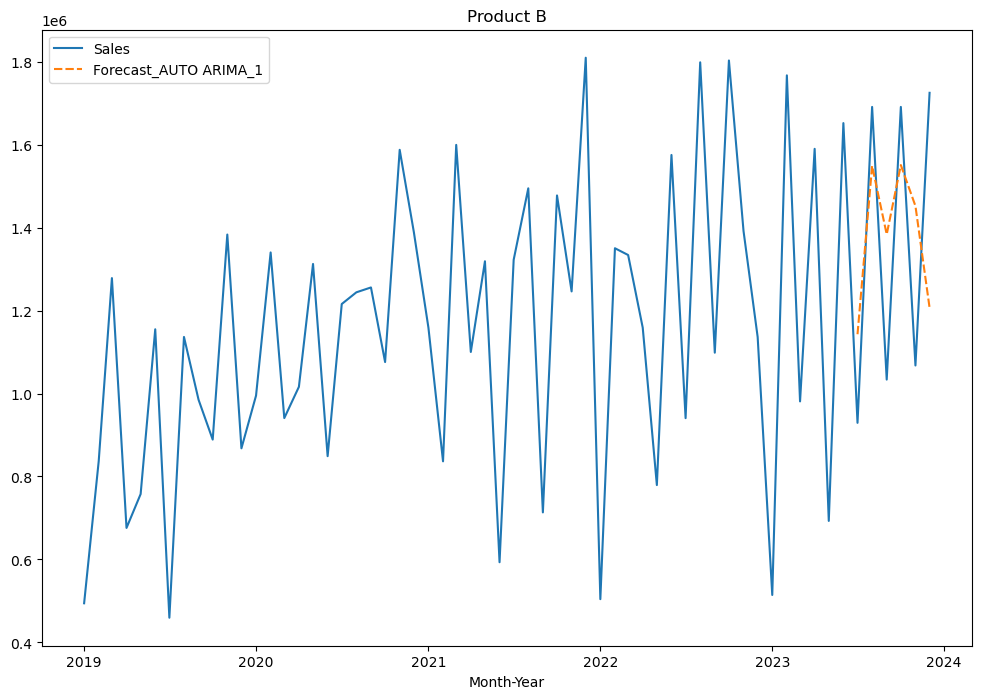

In [21]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product B')

In [22]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 291387.67920569534
MAPE - AUTO ARIMA: 0.23262955579809455
MSE - AUTO ARIMA: 104031582112.00275
RMSE - AUTO ARIMA: 322539.2722010806
